# Challenge 3

### Import Libraries

In [1]:
import os 
import math
import random
import zipfile
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models
from DataUtils.DownloadCapuchin import download_dataset,parse_datasets
from IPython import display
from matplotlib import pyplot as plt
from pydub import AudioSegment, effects
from pydub.generators import WhiteNoise
from multiprocessing.pool import ThreadPool

2021-12-14 15:13:40.783355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 15:13:40.783410: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### NOTE: Pydub requires FFMPEG so make sure you have that installed :
* [FFMPEG Setup Guide](https://github.com/jiaaro/pydub#getting-ffmpeg-set-up)

## Download Training Data
Script that does this is located in `/DataUtils/DownloadCapuchin.py` if you want to look at it or make changes but it should work out of the gate unless you are missing a package install or dont have FFMPEG installed correctly

In [2]:
download_dataset()
parse_datasets()

Finished Capuchinbird Call Download
Finished Other Sounds Download
Finished Capuchinbird Call Parsing
Finished Other Sounds Parsing


### Listen to Parsed Samples
If you want to hear a particular sound clip within Jupyter Notebooks you can listen with `display.display(display.Audio(file_path))`

In [2]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
Capuchin_File = "XC3776-6.wav" #random.choice(capuchin_files)
Not_Capuchin_File = random.choice(not_capuchin_files)
print(f"Displaying {Capuchin_File} which is an example of a Parsed Capuchinbird Call:")
display.display(display.Audio(os.path.join("Parsed_Capuchinbird_Clips",Capuchin_File)))
print(f"Displaying {Not_Capuchin_File} which is an example of a Parsed Other Noise:")
display.display(display.Audio(os.path.join("Parsed_Not_Capuchinbird_Clips",Not_Capuchin_File)))

Displaying XC3776-6.wav which is an example of a Parsed Capuchinbird Call:


Displaying night-insect-sounds-13.wav which is an example of a Parsed Other Noise:


### Data Augmentation
Similar to Image Recognition in order to produce a robust model you may want to Augment your training set with transformed samples. Here we provide a few examples that you can use to transform audio clips. 

In [3]:
def Add_White_Noise(sound, decibels = 50):
    """
    Add White Noise to an Audio Clip and return the new clip
    Note: sound should be an AudioSegment
    """
    noise = WhiteNoise().to_audio_segment(duration=len(sound))-decibels
    combined = sound.overlay(noise)
    return combined
def Normalize_Volume(sound):
    """
    Normalize the Volume of a Clip and return the new clip
    Note :sound should be an AudioSegment
    """
    normalized_sound = effects.normalize(sound) 
    return normalized_sound
def Filter_Out_High_Frequency(sound,cutoff = 8e3):
    """
    Filter out High Frequencies in a Clip and return the new clip
    Note: sound should be an AudioSegment and cutoff is in Hz (default is 8kHz)
    """
    filtered_sound = effects.low_pass_filter(sound,cutoff) 
    return filtered_sound
def Filter_Out_Low_Frequency(sound,cutoff = 8e3):
    """
    Filter out High Frequencies in a Clip and return the new clip
    Note: sound should be an AudioSegment and cutoff is in Hz (default is 8kHz)
    """
    filtered_sound = effects.high_pass_filter(sound,cutoff) 
    return filtered_sound

## Model Training (Spectrograph and CNN)

### Helper Functions

In [4]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary,desired_channels=1,)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [5]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
    [16000] - tf.shape(waveform),
    dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
    equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [6]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

### Build Dataset

In [7]:
# Set the seed value for experiment reproducibility.
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [8]:
data_dir = os.getcwd()
commands = ["Parsed_Capuchinbird_Clips","Parsed_Not_Capuchinbird_Clips"]
filenames_Capuchinbird = tf.io.gfile.glob(str(data_dir) + '/Parsed_Capuchinbird_Clips/*')
filenames_Not_Capuchinbird = tf.io.gfile.glob(str(data_dir) + '/Parsed_Not_Capuchinbird_Clips/*')
filenames =tf.concat([filenames_Capuchinbird, filenames_Not_Capuchinbird], 0)
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)

Number of total examples: 810


2021-12-14 13:52:49.283725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-14 13:52:49.283929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 13:52:49.283989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-14 13:52:49.284039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-14 13:52:49.296442: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [10]:
train_split = int(.8*num_samples)
val_split = int(.1*num_samples)
test_split = num_samples - train_split - val_split
train_files = filenames[:train_split]
val_files = filenames[train_split: train_split + val_split]
test_files = filenames[-1*test_split:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 648
Validation set size 81
Test set size 81


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

### Visualize Dataset

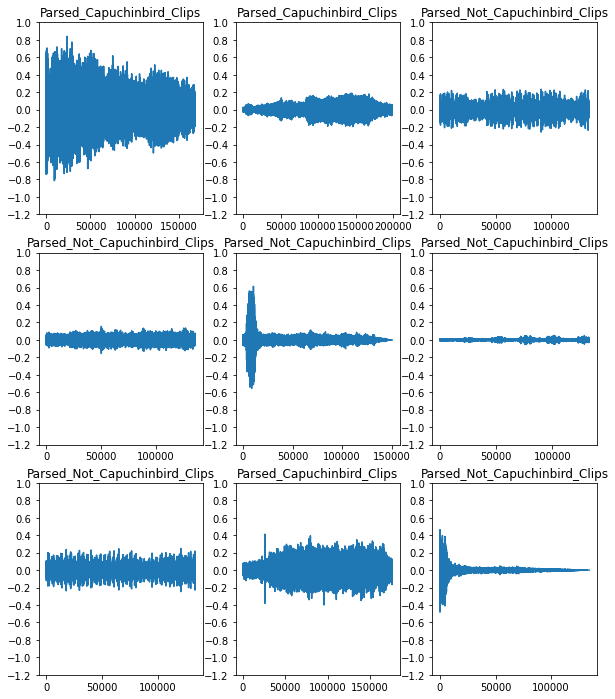

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [13]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Parsed_Capuchinbird_Clips
Waveform shape: (168000,)
Spectrogram shape: (124, 129, 1)
Audio playback


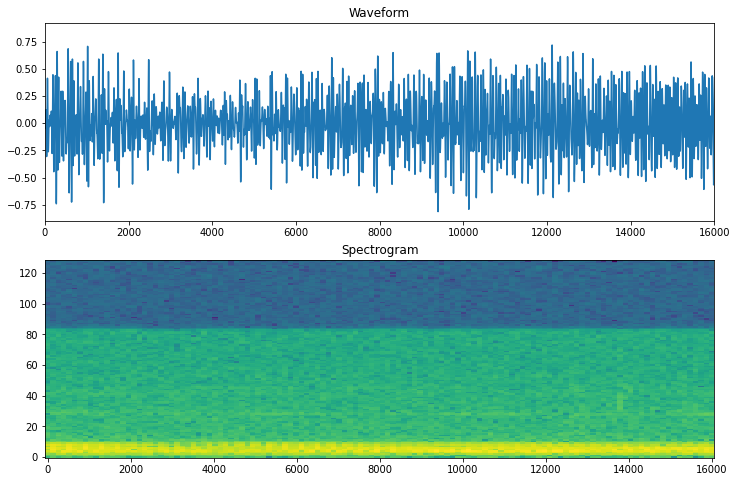

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [15]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

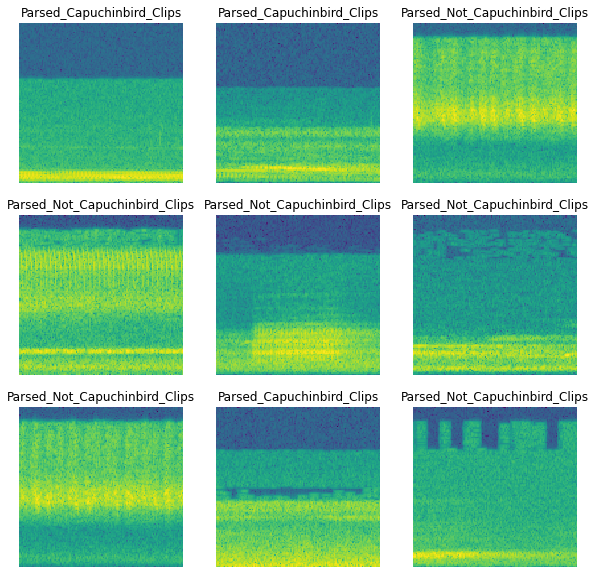

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

### Build and Train Model

In [17]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [18]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [19]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [20]:
EPOCHS = 20
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=5,
                                               restore_best_weights=True
                                              ),
)

Epoch 1/20
11/11 [==============================] - 2s 120ms/step - loss: 0.5515 - accuracy: 0.7546 - val_loss: 0.4334 - val_accuracy: 0.8148
Epoch 2/20
11/11 [==============================] - 1s 50ms/step - loss: 0.3863 - accuracy: 0.8025 - val_loss: 0.4126 - val_accuracy: 0.8025
Epoch 3/20
11/11 [==============================] - 1s 46ms/step - loss: 0.3314 - accuracy: 0.8426 - val_loss: 0.3646 - val_accuracy: 0.8395
Epoch 4/20
11/11 [==============================] - 0s 45ms/step - loss: 0.2741 - accuracy: 0.8812 - val_loss: 0.3005 - val_accuracy: 0.8642
Epoch 5/20
11/11 [==============================] - 0s 42ms/step - loss: 0.2565 - accuracy: 0.8966 - val_loss: 0.3284 - val_accuracy: 0.8642
Epoch 6/20
11/11 [==============================] - 0s 43ms/step - loss: 0.2142 - accuracy: 0.9167 - val_loss: 0.3011 - val_accuracy: 0.8765
Epoch 7/20
11/11 [==============================] - 0s 42ms/step - loss: 0.1743 - accuracy: 0.9306 - val_loss: 0.3068 - val_accuracy: 0.8642
Epoch 8/20
1

### Investigate Model Performance

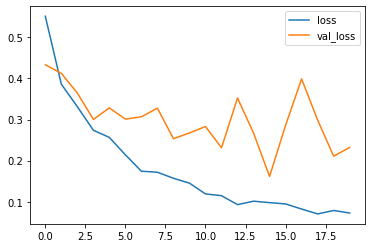

In [21]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [22]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(cnn_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 90%


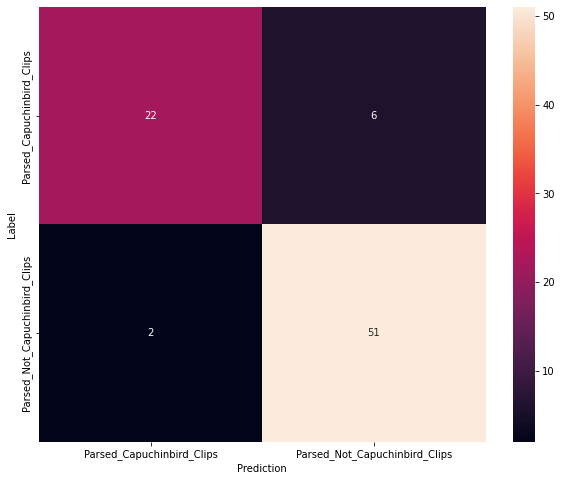

In [23]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Example Prediction on file

XC3776-5.wav


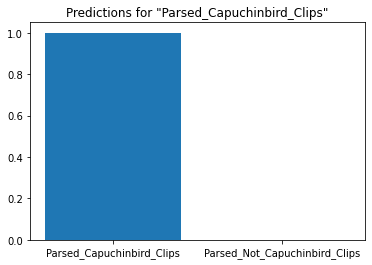

In [25]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
sample_file = random.choice(capuchin_files)
print(sample_file)
sample_ds = preprocess_dataset([os.path.join("Parsed_Capuchinbird_Clips",sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = cnn_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

## Model Training (Transfer Learning)

### Helper Functions 

In [26]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav
def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label
def extract_embedding(wav_data, label):
    """ run YAMNet to extract embedding from the wav data """
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings)
           )
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """ Split Train, Test and Validation Datasets out of Dataframe """
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=1842)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
# Filter out Annoying Tensorflow Warnings
tf.get_logger().setLevel('ERROR')

### Download YAMNet pretrained model 

In [27]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

### Build Training Set 

In [28]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
capuchin = []
for file in capuchin_files:
    if file.endswith('.wav'):
        capuchin.append(os.path.join("Parsed_Capuchinbird_Clips",file))
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
not_capuchin = []
for file in not_capuchin_files:
    if file.endswith('.wav'):
        not_capuchin.append(os.path.join("Parsed_Not_Capuchinbird_Clips",file))

In [29]:
capuchin_pd = pd.DataFrame({"filename":capuchin,"target":1})
not_capuchin_pd = pd.DataFrame({"filename":not_capuchin,"target":0})
dataset_pd = pd.concat([capuchin_pd,not_capuchin_pd],axis=0,ignore_index=True)
dataset_pd

,filename,target
0,Parsed_Capuchinbird_Clips/XC114131-0.wav,1
1,Parsed_Capuchinbird_Clips/XC114131-1.wav,1
2,Parsed_Capuchinbird_Clips/XC114131-2.wav,1
3,Parsed_Capuchinbird_Clips/XC114131-3.wav,1
4,Parsed_Capuchinbird_Clips/XC114131-4.wav,1
...,...,...
805,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0
806,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0
807,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0
808,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0


In [30]:
main_ds = tf.data.Dataset.from_tensor_slices((dataset_pd["filename"], dataset_pd["target"]))
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

2021-12-14 13:55:04.814422: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [31]:
# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [32]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(main_ds,len(dataset_pd))

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

### Build Model

In [33]:
yamnet_transfer_learning_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
], name='yamnet_transfer_learning_model')

yamnet_transfer_learning_model.summary()

Model: "yamnet_transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [34]:
yamnet_transfer_learning_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

### Train Model

In [35]:
history = yamnet_transfer_learning_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20


2021-12-14 13:55:28.080515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2401 of 10000
2021-12-14 13:55:38.084284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4912 of 10000


     20/Unknown - 21s 3ms/step - loss: 0.2838 - accuracy: 0.8672

2021-12-14 13:55:38.611118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2021-12-14 13:55:38.611171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2021-12-14 13:55:38.611181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2 of 1000
2021-12-14 13:55:38.612947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2021-12-14 13:55:49.010941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2449 of 10000
2021-12-14 13:55:58.996069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4990 of 10000


21/21 [==============================] - 41s 1s/step - loss: 0.2809 - accuracy: 0.8688 - val_loss: 0.1309 - val_accuracy: 0.9630
Epoch 2/20
 1/21 [>.............................] - ETA: 0s - loss: 0.0538 - accuracy: 1.0000

2021-12-14 13:55:59.200477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


21/21 [==============================] - 0s 8ms/step - loss: 0.1121 - accuracy: 0.9676 - val_loss: 0.1308 - val_accuracy: 0.9630
Epoch 3/20
21/21 [==============================] - 0s 8ms/step - loss: 0.0786 - accuracy: 0.9830 - val_loss: 0.0881 - val_accuracy: 0.9630
Epoch 4/20
21/21 [==============================] - 0s 8ms/step - loss: 0.0573 - accuracy: 0.9877 - val_loss: 0.1272 - val_accuracy: 0.9506
Epoch 5/20
21/21 [==============================] - 0s 8ms/step - loss: 0.0468 - accuracy: 0.9907 - val_loss: 0.0810 - val_accuracy: 0.9753
Epoch 6/20
21/21 [==============================] - 0s 8ms/step - loss: 0.0282 - accuracy: 0.9923 - val_loss: 0.0604 - val_accuracy: 0.9877
Epoch 7/20
21/21 [==============================] - 0s 8ms/step - loss: 0.0242 - accuracy: 0.9969 - val_loss: 0.0800 - val_accuracy: 0.9753
Epoch 8/20
21/21 [==============================] - 0s 8ms/step - loss: 0.0165 - accuracy: 0.9985 - val_loss: 0.0806 - val_accuracy: 0.9753
Epoch 9/20
21/21 [=============

### Investigate Model Performance

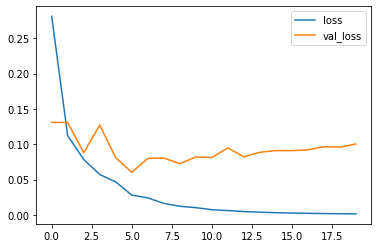

In [36]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [37]:
loss, accuracy = yamnet_transfer_learning_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

2021-12-14 13:56:20.718709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2437 of 10000
2021-12-14 13:56:30.701680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4810 of 10000


135/135 [==============================] - 21s 1ms/step - loss: 0.1272 - accuracy: 0.9671
Loss:  0.12724457681179047
Accuracy:  0.967129647731781


2021-12-14 13:56:31.644105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


## Use Model Outputs to Count Capuchinbird Calls
Now that we have a working model lets extend it to count Capuchinbird Calls and test out how well it works

### Build Simple Test Case Generator
You can Improve tests to use a variety of calls for Capuchin and Not Capuchin from the test set or other clips you gather or you can mix your own audio clips in another way and test them here.

In [38]:
def locations_to_approx_seconds(location):
    return str(location*3)
def locations_to_approx_result_row(location):
    return str(int(location*6.5))
def make_tests(capuchin_path,not_capuchin_path,capuchin_count):
    seconds = 1000
    capuchin_sound = AudioSegment.from_wav(capuchin_path)
    not_capuchin_sound = AudioSegment.from_wav(not_capuchin_path)
    total_clips = 60
    locations = random.sample(range(1, total_clips), capuchin_count)
    locations.sort()
    clip_positions = ",".join(map(str,locations))
    approx_locations_sec = ",".join(map(locations_to_approx_seconds,locations))
    approx_locations_result_row = ",".join(map(locations_to_approx_result_row,locations))
    print(f"Capuchin Calls are Located at [{clip_positions}] positions in the clip")
    print(f"Capuchin Calls are Located around [{approx_locations_sec}] seconds in the clip")
    print(f"Capuchin Calls are Located around [{approx_locations_result_row}] in the result rows")
    clips = []
    for i in range(total_clips):
        if i in locations:
            clips.append(capuchin_sound)
        else:
            test = random.sample([0,1],1)
            if test == 0:
                clips.append(WhiteNoise().to_audio_segment(duration=len(3*1000)))
            else:
                clips.append(not_capuchin_sound)
    final_clip = clips[0]
    for i in range(1,len(clips)):
        final_clip = final_clip + clips[i]
    output_file = "test.wav"
    final_clip.export(output_file, format="wav")
    return output_file

### Generate Test Case

In [39]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
Capuchin_File = random.choice(capuchin_files)
Not_Capuchin_File = random.choice(not_capuchin_files)
Num_Capuchin_Calls = 5
print(f"Using {Capuchin_File} and {Not_Capuchin_File} to generate {Num_Capuchin_Calls} Capuchinbird Calls")

not_capuchin_path = os.path.join("Parsed_Not_Capuchinbird_Clips",Not_Capuchin_File)
capuchin_path = os.path.join("Parsed_Capuchinbird_Clips",Capuchin_File)
test_file_name = make_tests(capuchin_path,not_capuchin_path,Num_Capuchin_Calls)

Using XC216012-0.wav and cricket-sounds-for-sleep-52.wav to generate 5 Capuchinbird Calls
Capuchin Calls are Located at [19,37,38,45,57] positions in the clip
Capuchin Calls are Located around [57,111,114,135,171] seconds in the clip
Capuchin Calls are Located around [123,240,247,292,370] in the result rows


### Generate Model Results

#### Illustration Gif from Tensorflow website on how YAMNet works

![](https://1.bp.blogspot.com/-CLyq7ilQIow/YDawZXp_NiI/AAAAAAAAEEg/vVa58jb24Fkw-LZPsezB_qMdnvndOYuzwCLcBGAsYHQ/s0/yamnet_animation%2B%25282%2529.gif)

In [40]:
testing_wav_data = load_wav_16k_mono(test_file_name)
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = yamnet_transfer_learning_model(embeddings).numpy()
result

2021-12-14 13:56:59.652579: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 152174592 exceeds 10% of free system memory.


array([[  7.9702024 ,  -8.887236  ],
       [  7.5824285 ,  -8.323081  ],
       [  6.0341587 ,  -6.707436  ],
       [  5.4410295 ,  -6.0912247 ],
       [  5.815843  ,  -6.708891  ],
       [  5.694477  ,  -6.5099683 ],
       [  7.612962  ,  -8.492825  ],
       [  9.175686  , -10.6603365 ],
       [  8.168532  ,  -9.5050125 ],
       [  7.487831  ,  -8.556378  ],
       [  6.6484737 ,  -7.849099  ],
       [  7.8250995 ,  -8.651595  ],
       [ 10.007199  , -11.146779  ],
       [  7.3688393 ,  -8.704991  ],
       [  7.053376  ,  -8.003289  ],
       [  5.732434  ,  -6.660413  ],
       [  5.508363  ,  -6.2426496 ],
       [  6.8899536 ,  -7.8450365 ],
       [  7.874699  ,  -8.967105  ],
       [  9.545274  , -10.989643  ],
       [  9.516627  , -10.594378  ],
       [  8.652472  ,  -9.721686  ],
       [  4.968537  ,  -5.9842725 ],
       [  8.162066  ,  -9.333732  ],
       [  8.812831  ,  -9.816409  ],
       [  8.596002  ,  -9.588344  ],
       [ 10.150584  , -11.716697  ],
 

### Simple Capuchinbird Call Counter
This code is counting all Positive Model Scores for the Positive Class (Capuchinbird) that occur in a row as a single call. It is easy to see cases where this will fail to properly count the calls so building a more complex Call Counter will be up to you and an important piece of your solution

In [41]:
count = 0
previous_pos = 0
capuchin_count = 0
print("Embeddings with Positive Val for Capuchinbird Call:")
for row in result:
    if row[1]>0:
        if count - previous_pos > 1:
            capuchin_count += 1
        previous_pos = count
        value = '%.2f' % round(row[1],2)
        if count <100:
            print(f"  row:  {count} value: {value}")
        else:
            print(f"  row: {count} value: {value}")
    count += 1
print(f"Found {capuchin_count} of {Num_Capuchin_Calls} Capuchin Calls!")

Embeddings with Positive Val for Capuchinbird Call:
  row: 119 value: 4.74
  row: 120 value: 3.25
  row: 121 value: 5.25
  row: 122 value: 9.05
  row: 123 value: 7.39
  row: 124 value: 4.56
  row: 125 value: 3.92
  row: 234 value: 1.42
  row: 235 value: 4.53
  row: 236 value: 5.83
  row: 237 value: 8.35
  row: 238 value: 7.24
  row: 239 value: 7.23
  row: 240 value: 5.86
  row: 243 value: 3.95
  row: 244 value: 1.07
  row: 245 value: 4.78
  row: 246 value: 8.66
  row: 247 value: 6.32
  row: 248 value: 5.40
  row: 249 value: 5.08
  row: 289 value: 3.45
  row: 290 value: 4.90
  row: 291 value: 4.78
  row: 292 value: 4.74
  row: 293 value: 5.54
  row: 294 value: 2.77
  row: 295 value: 3.90
  row: 366 value: 1.21
  row: 367 value: 2.72
  row: 368 value: 7.90
  row: 369 value: 9.04
  row: 370 value: 7.69
  row: 371 value: 4.69
  row: 372 value: 6.02
Found 5 of 5 Capuchin Calls!


## Sample Output File
Your submission should consist of a csv with scores for all the clips in the `Forest Recordings` Folder and should have two columns: clip_name and call_count. There should be 100 audio clips so make sure you have scores for clips 0-99!

In [42]:
clip_names = os.listdir("Forest Recordings")
clip_names.sort()
counts = [0]*len(clip_names) # Change with your scores
submission_df = pd.DataFrame({"clip_name":clip_names,"call_count":counts})
submission_df.to_csv("submission.csv",index=False)
submission_df

,clip_name,call_count
0,recording_00.mp3,0
1,recording_01.mp3,0
2,recording_02.mp3,0
3,recording_03.mp3,0
4,recording_04.mp3,0
...,...,...
95,recording_95.mp3,0
96,recording_96.mp3,0
97,recording_97.mp3,0
98,recording_98.mp3,0


## Next Steps:
* Make a Capuchinbird Call Count for each clip in the `Forest Recordings` Folder
* Iterate Model/Training Set/Call Counter to Improve Results